## Hodgkin-Huxley model

### intro or smth like that

## Notes for the moment

### Notes on description of model
Models formlates current such that:
* $\displaystyle \sum_{k}^{}$Ik = gNa m^3 h (u - ENa) + gK n^4 (u - EK) + gL (u - EL).

If all channels open, transmit current with max conductance gNa and gK respectively (other channel has constant conductance given as 1/R)

<li>ENa, EK and EL, AND the conducatances are empirical parameters, and are the reversal potentials:
<li><b>Reversal potential:</b> reversal potential of an ion is membrane potential at which no net low of that particular ion fom one side of membrane to the other</li>
<i>Original value of these parameters reported by Hodgkin and Huxley are given on website http://icwww.epfl.ch/~gerstner/SPNM/node14.html.</i><br>
NOTE: need to shift voltage values by -65mV because those were given with a resting potential assumed to be 0, but not the case
</li>

#### m, n and h:
are called the "gating variables" and evolve according to differential eqs (given on websit). Those equations include alpha and beta factors that both are expressions of the membrane volatage mu. 

### Notes on dynamics of model
<li>m and n increase with mu, while h decrease (graph of this to support it)</li>
<li> --> if some external input cause membrane voltage mu to rise, conductance of Na channels increase --> positive Na ions flow into cell and raise even further membrane potential mu. If large enough --> action potential initiated.</li>
<li><b>Threshold type behavior:</b>action potential (which is a traveling spike in membrane potential) is initiated by a peak in current. If that peak in current is not high enough, don't get high large-soike excursion, but just small var. </li>
<li><b>Pulling the membrane voltage back down:</b>the K+ channel is outward so when open, it lowers potential. --> Overall effect is large spike in potential, and then h factor and K+ channel pull it back down (with a temp overshoot since temporarly get potential below rest potential.</li>
<li><b>With constant input current:</b> if I larger than some critical value known (I_theta) observe regular spiking in membrane potential. </li>
<li><b>Step current input:</b> whether triggers action potential or not depends on both the constant current value and the spike value too.</li> 
<li><b>Interesting element, refratoriness:</b> during hyperpolarization period followed action potential due to input current, neuron incapable of reacting to same input current</li>


### What type of current input is associated with vision stimulus from retina? 

#### Additional Notes:
Also need to figure out: <ul>
    <li>Do I have to take into account the what happens with synapses too?</li>
    <li>How much time needed to send response signal once signal reached brain?</li>
    <li>How long is the path from retina to brain and from brain to right arm?</li>
    <li><b>Example situation that will be chosen for project:</b> to make things more dramatic, will assume you are in a boxing match, and see your opponent's arm starting to move towards your face. Assume arm moving at 5 m/s (maybe change that val later), assuming separation between you two is 1.5m, at what distance from your face will arm be when start reacting?</li>
    <li>Ask papa for length of neuronal path, time for brain to analyze signal, what happens in synapses, etc</li>
    </ul>
    
### Setup so far: 
<ul>
    <li>Decided would start by modeling one neuron with length <i>1 cm</i></li>
    <li>Seems like each cicuit represents a part of the axon <b><i>parallel</i></b> to the direction the signal is being transmitted --> pick axon length, number of segments to cut it in, and associate a distinct ciruit with each of those (need to store the different parameters associated with each of them --> make a class that contains all variables need for circuit and make array of instances of that object). </li> 
    <li>What wanna "plot"/see evolve is the membrane voltage. Relation with current given on website --> calculate current to get mu. 

In [1]:
import numpy as np              ## numpy is a library that inclues most of the numerical funciton you will need
import matplotlib.pyplot as plt ## this is the library we use to plot
from math import exp            ## used for diff eq of the Hodgkin-Huxley model

In [2]:
class HHcircuit: # Representation of the circuit of the HH model, physically represents 
                 # membrane and ion channels of a neuron fiber
        
    def __init__(self, gNa, gK, gL, C, mu, E_Na, E_K, E_L): # constructor
        self.gNa = gNa
        self.gK = gK
        self.gL = gL
        self.m = 0.0
        self.n = 0.0
        self.h = 0.0
        self.C = C
        self.mu = mu
        
        self.E_Na = E_Na
        self.E_K = E_K
        self.E_L = E_L
        
        self.recorded_mu = []
        
    def update_m(self, dt): # updates m using diff eqs of HH model
        alpha_m = (2.5-0.1*self.mu)/(exp(2.5-0.1*self.mu) - 1)
        beta_m = 4*exp(-self.mu / 18)
        dm = dt * (alpha_m*(1-self.m) - beta_m*self.m)
        self.m += dm
        return self.m
    
    def update_n(self, dt): # updates n using diff eqs of HH model
        alpha_n = (0.1-0.01*self.mu)/(exp(1-0.1*self.mu) - 1)
        beta_n = 0.125*exp(-self.mu / 80)
        dn = dt * (alpha_n*(1-self.n) - beta_n*self.n)
        self.n += dn
        return self.n
    
    def update_h(self, dt): # updates h using diff eqs of HH model
        alpha_h = 0.07*exp(-self.mu / 20)
        beta_h = 1 / (exp(3-0.1*self.mu)+1)
        dh = dt * (alpha_h*(1-self.h) - beta_h*self.h)
        self.h += dh
        return self.h
    
    def sum_I_channels(self): # returns current through capacitor 
        s = 0
        s += self.gNa* (self.m)**3 *self.h*(self.mu-self.E_Na)
        s += self.gK* (self.n)**4 *(self.mu-self.E_K)
        s += self.gL*(self.mu - self.E_L)
        return s

In [48]:
### Numerical values, obtained from experiments
# E_Na = 50.0 #mV
# E_K = -77.0
# E_L = -54.4
# gNa = 120.0 # mS/cm^2
# gK = 36.0
# gL = 0.3
# mu0 = -65.0 # value given by shift from paper

# non shifted values
E_Na = 115.0 # mV
E_K = -12.0
E_L = 10.6
gNa = 120.0 # mS/cm^2
gK = 36.0
gL = 0.3
mu0 = 0.0 # assumes rest potential of membrane is 0mV

# C_rate = 1.0  # microFarads / cm^2
C = 2.0 # to verify

In [189]:
def run_experiment(T, I_peak, C): 
    neuron = HHcircuit(gNa, gK, gL, C, mu0, E_Na, E_K, E_L)
    recorded_mu = []
    times = []

    t_steps = 10000
    dt = T / t_steps
    t = 0.0 # ms

    first_pass = False # enables to have a current peak of duration dt only

    #temp 
#     I_out = []
    I_channels = []
#     speeds = []
#     I_C = []
#     I_p = []

    for i in range(t_steps):
        # update HH model coefficients
        neuron.update_n(dt)
        neuron.update_m(dt)
        neuron.update_h(dt)

        # Update voltage through Capacitor (membrane)
        sum_currents = I_peak - neuron.sum_I_channels()
        I_C.append(sum_currents)

        d_mu = sum_currents / neuron.C * dt
        neuron.mu += d_mu

        # save and update data
        recorded_mu.append(neuron.mu)
        times.append(t)
        t += dt

    #     I_out.append(C*d_mu/dt + sum_currents)
        I_out.append(sum_currents)
        I_channels.append(neuron.sum_I_channels())
        I_p.append(I_peak)

        # makes sure the current peak is just a pulse of duration dt
        if not first_pass: 
            I_peak = 0.0
            first_pass == True
    
    return recorded_mu, times, I_channels


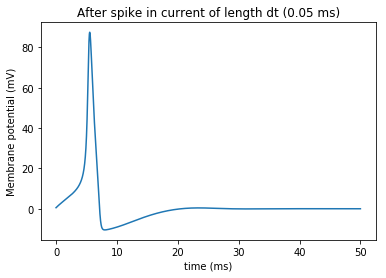

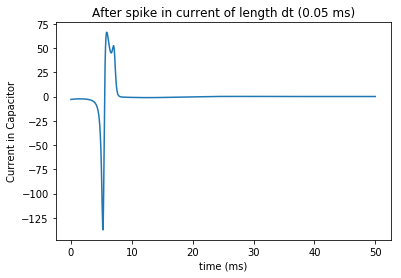

In [190]:
recorded_mu, times, I_channels = run_experiment(50.0, 100.0, 1.0)

plt.plot(times, recorded_mu)
plt.xlabel("time (ms)")
plt.ylabel("Membrane potential (mV)")
plt.title("After spike in current of length dt ("+str(dt)+" ms)")
plt.show()

# plt.plot(times, I_out)
plt.plot(times, I_channels)
plt.xlabel("time (ms)")
plt.ylabel("Current in Capacitor")
plt.title("After spike in current of length dt ("+str(dt)+" ms)")
plt.show()

In [195]:
# find period of 
def find_period(recorded_mu, times):
    axis_cross = 0
    for i in range(1, len(recorded_mu)-1):
        # checks if 2 values in a row are of different sign (indicates x-axis cross)
        if recorded_mu[i]/recorded_mu[i-1] < 0: 
            axis_cross += 1
        if axis_cross == 2:
            return times[i]
    return 2*times[-1]

In [204]:
capacitances = np.linspace(0.5, 10.0, num=50)

periods = []
first = True
times = []

for C_i in capacitances:
    mus, t, _ = run_experiment(100.0, 100.0, C_i)
    if first:
        first = False 
        times = t
    T = find_period(mus, times)
    periods.append(T)

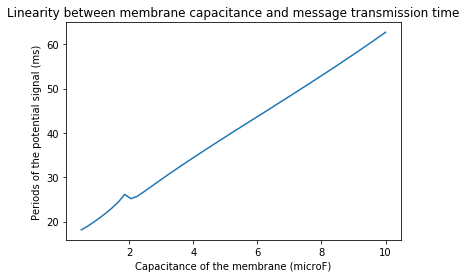

In [205]:
plt.plot(capacitances, periods)
plt.xlabel("Capacitance of the membrane (microF)")
plt.ylabel("Periods of the potential signal (ms)")
plt.title("Linearity between membrane capacitance and message transmission time")
plt.show()

Can see <b>linear relation</b> ... 
Considering neuron fibers of same fiber and diameter, capactance directly proportional to length of neuron fiber. --> can use the period time as a way of measuring time it takes action potential to travel through entire fiber --> given know length of fiberm can obtain speed

BUT small irregularities --> will use several values and average it out

In [199]:
# Calculate slope from previous data 
slope = (periods[-1] - periods[0]) / (capacitances[-1] - capacitances[0])
print(slope)

4.693684210525902


In [208]:
# Scientifically known numerical values
diam_fiber = 10.0e-2 # micro_m
C_per_area = 1.0 # microF/cm^2

neuron_length = 1.0 # cm 
area = np.pi * diam_fiber * neuron_length # cm^2
C = area * C_per_area # microF/cm^2
period_signal = C * slope # ms 

speed = neuron_length / period_signal # cm / ms
converted_speed = speed*10**-2/10**-3 # m/s
print(speed, converted_speed)

0.6781663868011388 6.781663868011389


In [187]:
# Scientifically known numerical values
diam_fiber = 10.0e-2 # micro_m
C_per_area = 1.0 # microF/cm^2

lengths = np.linspace(10.0, 70.0, num=20) # cm
capacitances = C_per_area * np.pi * diam_fiber * lengths
# print(capacitances[-])

velocities = []
t = []
mus = []
mus0 = []
for i in range(len(capacitances)): 
    mus, t, _ = run_experiment(20.0, 100.0, capacitances[i])
    if i==0:
        mus0 = mus
    T = find_period(mus, t)
    v = T / lengths[i]
    velocities.append(v)



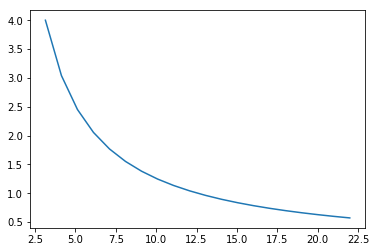

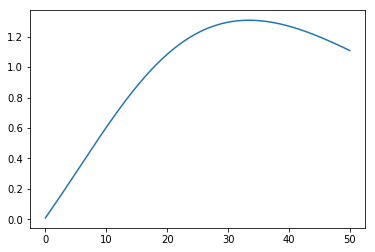

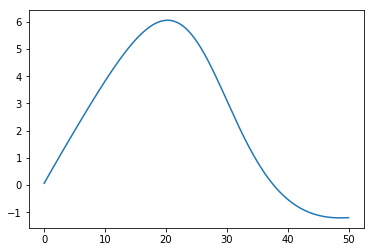

In [188]:
plt.plot(capacitances, velocities)
plt.show()
plt.plot(times, mus)
plt.show()
plt.plot(times, mus0)
plt.show()

In [ ]:
# Trying eq 7 method 
# Membrane represented by capacitor so I_membrane = I_C

# exp specifications 
L = 1.0 # cm 
length_steps = 100
dL = L/length_steps

C_per_area = 1.0e-6 # Farads/cm^2

D = 1.0e-3 # cm, diameter of neuron fiber
R = D/2
dArea = np.pi * R**2 * dL
dC = C_per_area * dArea

a = 5.0e-7 # cm, membrane thickness

R_a_per_cm = 100 # ohms/cm
R_a = R_a_per_cm * L


velocities = []
for i in range(1, len(times)-1):
    deriv2nd = abs(recorded_mu[i+1]-2*recorded_mu[i]+recorded_mu[i-1]) / dt**2
    I = I_C[i]
    
    v_square = deriv2nd * a / abs(2*I*R_a)
    velocities.append(v_square**0.5)

plt.plot(times[1:-1], velocities)
plt.show()

https://www.sciencedirect.com/science/article/pii/B9780080450469014133 read this to understand and figure out eq to get action potential speed

Question now is how do I used this to make several of these circuits in series? 
Should just be circuit in series so basically all I need is figure out output current of each of these circuits

<b> need to figure out how to find velocity of action potentials</b>
<ul>
    <li>First: try to find stuff online</li>
    <li>Maybe can use formula with current density that gives speed of charge carriers (but feel like thatd be the speed of ions flowing in and out of the membrane</li>
    <li>OR, can just find period of peak and use length of "part of axion", but dont really see how that links to a continuous case</li>
    </ul>
    
  cytoplasmic axial resistance value: 100 ohms cm (https://link.springer.com/content/pdf/10.1007%2F978-1-4614-7320-6_35-2.pdf) 
  
  https://www.quora.com/Why-does-nerve-conduction-velocity-scale-with-the-diameter-of-the-nerve diameters of nerve fibers and speeds of action potentials
  
  https://en.wikipedia.org/wiki/Optic_nerve#Structure diameter of optic nerve (4.5mm)
  
  http://www.math.pitt.edu/~bdoiron/assets/ermentrout-and-terman-ch-1.pdf (1.21):
      eq for velocity: I(x, t) = -pi*a^(2/r_l dV_m(x,t)/dx) 
      
      
  http://umdberg.pbworks.com/w/page/84111850/Capacitance%20in%20nerve%20cells dimensions of axons

 NEW STRATEGY: 
   <b>Iterative approach</b>:
   Try out different speeds and see which one produces normal signal
   <ul>
    <li>Have evolution of signal for one neuron --> pick speed and see if anything gives something similar</li>
    
    
    
    
    NEWWWWW
    have input current --> calculte amount that goes into first circuit --> rest goes to next circuit. Current in first circuit then reverses --> fed back into main channel and so on... 
    CAn see when reached end of fiber by seenig when last circuit reaches max voltage OR when current through last circuit is 0 again 
    To find current that goes into first circuit, could just assume everything goes into it 

In [151]:
#

# exp specifications 
L = 1.0 # cm 
length_steps = 100
dL = L/length_steps

C_per_area = 1.0e-6 # Farads/cm^2

D = 1.0e-3 # cm, diameter of neuron fiber
R = D/2
dArea = np.pi * R**2 * dL
dC = C_per_area * dArea

a = 5.0e-7 # cm, membrane thickness

T = 100.0 # ms
time_steps = 1000
dt = T / time_step
t = 0.0 
I_peak = 100.0


# creating objects
times = []
n = HHcircuit(gNa, gK, gL, C, mu0, E_Na, E_K, E_L)
neurons_array = []
neurons_reached = []
for i in range(length_steps):
    neurons.append(n)
    neurons_reached.append(False)

index_prev = -1
index_curr = 0

I_central = I_peak
I_previous = 0.0
    
while index_curr < len(neurons_reached): 
    I_in = I_central
    
    n_prev = neurons_array[index_prev]
    n_curr = neurons_array[index_array]
    
    n_prev.update_n(dt)
    n_prev.update_m(dt)
    n_prev.update_h(dt)
    
    sum_currents_prev = I_previous - n_prev.sum_I_channels()
    d_mu_prev = sum_currents_prev / n_prev.C * dt
    n_prev.mu += d_mu_prev
    I_out = n_prev.C*d_mu/dt + sum_currents_prev


    
    
    n_curr.update_n(dt)
    n_curr.update_m(dt)
    n_curr.update_h(dt)
    sum_currents_curr = I_in - n_curr.sum_I_channels()
    d_mu_curr = sum_currents_curr / n_curr.C * dt
    n_curr.mu += d_mu_curr
    
    
    
    I_out = C*d_mu/dt + sum_currents


    t += dt
    times.append(t)
    
    

NameError: name 'time_step' is not defined